In [1]:
import functools
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
from ott.tools.gaussian_mixture import gaussian_mixture
from ott.core import bar_problems
from ott.core import continuous_barycenter
from ott.geometry import costs

In this notebook we demonstrate how we can compute Wasserstein barycenters of mixtures of Gaussians.

# Generate the Gaussian Mixture Models.

 First, we randomly generate the mixtures of Gaussians. 

For each GMM we chose an offset $c$ for the means of the components and a parameter $s\geq0$ that affects the covariance matrices of the components.

The means of the components of a GMM are generated as:

$$\mu = c + u$$

where $u$ follows the uniform distribution $\mathcal{U}(0,|c|)$. 

The covariances of the components of a GMM are generated as:

$$C = I + s * AA^\top$$

where $A$ follows a standard normal distribution and $I$ is the identity matrix. 

Notice that for $s=0$ the covariance matrices are equal to the identity matrix and therefore the Gaussians of the GMM are isotropic in that case.

We generate two GMMs, each composed of two components. We take into account equally each of the GMMs in the barycenter computation and, therefore, set the barycentric weight corresponding to each GMM to be equal to 0.5.

In [3]:
dim = 2 # the dimension of the Gaussians
n_gmms = 2 # the number of GMMs whose barycenter will be computed
n_components = 2 # the number of components of the GMMs  
barycentric_weights = jnp.array([0.5, 0.5]) # the barycentric weights for the GMMs
epsilon = 0.1 # the entropy regularization parameter

In [4]:
key = jax.random.PRNGKey(seed=0)
keys = jax.random.split(key, num=3)

In [5]:
# Create the seeds for the random generation of each measure.
seeds = jax.random.randint(keys[0], shape=(n_gmms,), minval=0, maxval=100)

We set the offsets $c$ for each GMM to be different so that they can be easily visualized.

In [6]:
# Offsets for the means of each GMM
cs = jnp.array([-10, 10])

We select the parameter $s$ for each GMM. The first GMM is chosen to be composed of isotropic Gaussians.

In [7]:
# Parameter that controls how significant the off-diagonal elements of the covariances of a GMM will be. 
# When set to zero, the covariances of a GMM are diagonal.
ss = jnp.array([0, 0.9])

In [8]:
assert cs.size == n_gmms
assert ss.size == n_gmms
assert seeds.size == n_gmms
assert jnp.array_equal(jnp.absolute(ss), ss)

We create an instance of the Bures cost class in order to compute distances between the GMMs, create the observations whose log probabilities under the GMM model are evaluated and generate the random GMMs.

In [9]:
# Create an instance of the Bures cost class.
b_cost = costs.Bures(dimension=dim)

In [10]:
# Create the observations
x1 = np.linspace(-25.0, 25.0)
x2 = np.linspace(-25.0, 25.0)
x, y = np.meshgrid(x1, x2)
obs = np.array([x.ravel(), y.ravel()]).T

In [11]:
def generate_random_gmm(num_components, dimension, bures_cost, c, s, observations, a=None, rng=0): 
    """
    Function that generates a random Gaussian Mixture Model.
    Args:
        num_components: The number of components of the Gaussian mixture model.
        dimension: The dimension of the Gaussian mixture model.
        bures_cost: An instance of the Bures cost class.
        c: Offset for the means of the GMM.
        s: Parameter that controls how significant the off-diagonal elements of the covariance will be.
        observations: The points whose probabilities under the GMM model are evaluated.
        a: The weights of each component of the GMM. By default, a uniform distribution is considered.
        rng: The seed used for the pseudo-random generator.
    Returns:
        x: The concatenated means and covariances (raveled) of a GMM's components. 
        a: The weights of each component of the GMM.
        neg_log_prob: The negative log probability of the observations.
    """
    if a == None:
        a = jnp.ones(num_components) / num_components
    key = jax.random.PRNGKey(rng)
    keys = jax.random.split(key, num=2)
    means = c + jax.random.uniform(keys[0], shape=(num_components, dimension), minval=0, maxval=jnp.absolute(c))
    covs = jax.vmap(lambda u: jnp.eye(u.shape[0]) + s * u @ jnp.transpose(u), in_axes=0)(
        jax.random.normal(keys[1], (num_components, dimension, dimension)))
    x = bures_cost.means_and_covs_to_x(means, covs)
    gmm_generator = gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(mean=means,
                                                                                     cov=covs,
                                                                                     component_weights=a)
    neg_log_prob = - gmm_generator.log_prob(observations)
    
    return x, a, neg_log_prob

In [12]:
# generate the GMMs whose barycenter will be computed
ys, bs, n_log_prob = jax.vmap(generate_random_gmm, in_axes=(None, None, None, 0, 0, None, None, 0), out_axes=(0, 0, 0))(n_components, dim, b_cost, cs, ss, obs, None, seeds)

In [13]:
assert ys.shape == (n_gmms, n_components, dim * (1 + dim))
assert bs.shape == (n_gmms, n_components)
assert n_log_prob.shape == (n_gmms, x.shape[0] * x.shape[1])

# Compute the Wasserstein barycenter of the GMMs.

We can now compute the barycenter of the input GMMs. We determine the number of components of the barycenter GMM and solve the barycenter problem.

In [14]:
# Determine the size of the barycenter. This is equivalent to the number of components of the barycenter GMM.
bar_size = 2

In [15]:
# Initialize the means and the covariances of the GMM barycenter.
x_init_means = jax.random.uniform(keys[1], (bar_size, dim))
x_init_covs = jax.vmap(
        lambda u: u @ jnp.transpose(u), in_axes=0
    )(
        jax.random.uniform(keys[2], (bar_size, dim, dim))
    )

x_init = b_cost.means_and_covs_to_x(x_init_means, x_init_covs)

In [16]:
# Create a barycenter problem.
bar_p = bar_problems.BarycenterProblem(
        ys,
        bs,
        weights=barycentric_weights,
        num_per_segment=jnp.repeat(n_components, n_gmms),
        num_segments=n_gmms,
        max_measure_size=n_components,
        cost_fn=b_cost,
        epsilon=epsilon
    )

In [17]:
# Create a Wasserstein barycenter solver.
solver = continuous_barycenter.WassersteinBarycenter(lse_mode=True, jit=True)

In [18]:
# Compute the barycenter.
out = solver(bar_p, bar_size=bar_size, x_init=x_init)
barycenter = out.x

Now that we have computed the barycenter, we can extract the means and the covariances of its components and compute the log probabilities at the observations.

In [19]:
# Extract the means and covariances of the barycenter.
means_bary, covs_bary = b_cost.x_to_means_and_covs(barycenter)

In [20]:
# Create a GMM with the means and the covariances of the computed barycenter.
gmm_generator_bary = gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
    mean=means_bary,
    cov=covs_bary,
    component_weights=jnp.ones(bar_size)/bar_size)

In [21]:
# Compute the negative log probabilities at the observations under the barycenter GMM.
n_log_prob_bary = - gmm_generator_bary.log_prob(obs)

# Visualize the results.

We now visualize the two GMMs and their barycenter.

In [22]:
# Reshape the log probabilities in order to plot
n_log_prob = n_log_prob.reshape((n_gmms, x.shape[0], x.shape[1]))
n_log_prob_bary = n_log_prob_bary.reshape((x.shape[0], x.shape[1]))

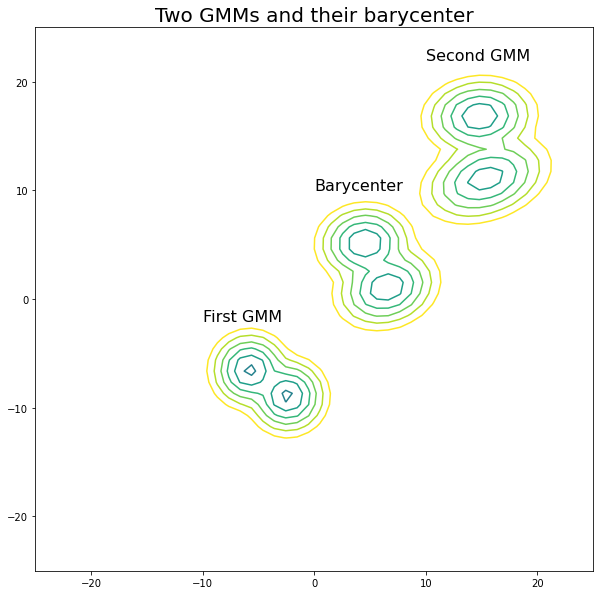

In [23]:
plt.figure(figsize=(10,10))

CS1 = plt.contour(
    x, y, n_log_prob[0, :, :], norm=LogNorm(vmin=1.0, vmax=10.0), levels=np.logspace(0, 1, 10)
)

CS2 = plt.contour(
    x, y, n_log_prob[1, :, :], norm=LogNorm(vmin=1.0, vmax=10.0), levels=np.logspace(0, 1, 10)
)

CS3 = plt.contour(
    x, y, n_log_prob_bary, norm=LogNorm(vmin=1.0, vmax=10.0), levels=np.logspace(0, 1, 10)
)

plt.annotate('First GMM',(-10,-2), fontsize=16)
plt.annotate('Second GMM',(10,22), fontsize=16)
plt.annotate('Barycenter',(0,10), fontsize=16)

plt.title("Two GMMs and their barycenter", fontsize=20)
plt.axis("tight")
plt.show()